In [8]:
import sys
sys_path = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/main'
sys.path.append(sys_path)
from my_tiny_cuda import my_MLP
from tools import ShiftedLegendrePolynomial2D, generate_grid_points, sample_all_boundary
from gradient import grad1, grad2
import torch
import numpy as np
import tinycudann as tcnn
import json
device = 'cuda'

In [9]:
class Heat_equation(torch.nn.Module):
    def __init__(self,k = 1, L = 1):
        super().__init__()
        self.k = k
        self.L = L
        self.tau = 1e-4
    def strong_form(self,X,grad_result):
        du_dt,d2u_dx2 = grad_result["du_dx"],grad_result["d2u_dy2"]
        result = du_dt - self.k*d2u_dx2
        return result
    def weak_form(self,X,grad_result, grad_result_v):
        # The shape of grad_result is (batch_size)
        # The shape of grad_result_v is (batch_size,max_order^2)
        du_dt,du_dx = grad_result["du_dx"].unsqueeze(1),grad_result["du_dy"].unsqueeze(1)
        v, dv_dx = grad_result_v["u"],grad_result_v["du_dy"]
        result = du_dt* v + du_dx * dv_dx
        return result
    def BC_function(self,X):
        # return torch.sin(X[:,0]*torch.pi)*torch.sin(X[:,1]*torch.pi)
        return self.real_solution(X)
    def real_solution(self,X):
        return torch.exp(-self.k*(torch.pi/self.L)**2*X[:,0])*torch.sin(X[:,1]*torch.pi/self.L)

In [10]:
with open(r"D:\Research_CAE\MyTinyCUDANN\tiny-cuda-nn\main\Wave_equation\Tests\config_1.json") as f:
    config = json.load(f)
# config["encoding"]["base_resolution"] = 4
mlp = my_MLP(activation = torch.nn.Tanh(), n_input_dims = int(config["encoding"]["n_levels"]*config["encoding"]["n_features_per_level"]),
            n_hidden = 1, width = 64,
            spectral_norm = False,dtype = torch.float32).to(device)
encoding = tcnn.Encoding1(2, config["encoding"],dtype=torch.float32)
model = torch.nn.Sequential(encoding,mlp).to(device)
optimizer_pretrain = torch.optim.Adam([
            {'params':encoding.parameters()},
            {'params':mlp.parameters(),'weight_decay':1e-6},
        ], lr=config["optimizer"]['learning_rate'], eps=1e-15)

equation = Heat_equation()
boundary_sample_points = sample_all_boundary(1000)
f_boundary = equation.BC_function(boundary_sample_points).to(device)
grid_points_resolution = 100
base_grid_points = generate_grid_points(grid_points_resolution, field_min = 0, field_max = 1 - 1/grid_points_resolution)
max_order = 4
test_function = ShiftedLegendrePolynomial2D(max_order).to(device)
v = test_function(base_grid_points[:,0],base_grid_points[:,1])
dv_dx, dv_dy = test_function.derivatives(base_grid_points[:,0],base_grid_points[:,1])
grad_result_v = {"u":v,"du_dx":dv_dx,"du_dy":dv_dy}
MSELoss = torch.nn.MSELoss().to(device)

In [11]:
n_step_pretrain = 1000
n_step_decay_pretrain = 200
# Train for BC
model.train()
for i in range(1, n_step_pretrain+1):
    
    optimizer_pretrain.zero_grad()

    loss = MSELoss(model(boundary_sample_points),f_boundary)
    
    loss.backward()
    optimizer_pretrain.step()   
    if i%n_step_decay_pretrain == 0:
        print('Iter:',i,'loss_pretrain:',loss.item())
        for _ in optimizer_pretrain.param_groups:
            _['lr'] = _['lr']/2

Iter: 200 loss_pretrain: 7.899674803191203e-10
Iter: 400 loss_pretrain: 3.2091931889688396e-10
Iter: 600 loss_pretrain: 2.7010971237473314e-10
Iter: 800 loss_pretrain: 2.5059906927360487e-10
Iter: 1000 loss_pretrain: 2.409862587260392e-10


In [12]:
# Get boundary values
grid_values = {}
boundary_name_list = ["left","bottom","right","top"]
with torch.no_grad():
    for name, p in encoding.named_parameters():
        for fixed_bounary_name in boundary_name_list:
            if fixed_bounary_name in name:
                grid_values[fixed_bounary_name] = p

# New grids
encoding = tcnn.Encoding1(2, config["encoding"],dtype=torch.float32)
model = torch.nn.Sequential(encoding,mlp)
opti_group = []
with torch.no_grad():
    for name, p in encoding.named_parameters():
        for fixed_bounary_name in boundary_name_list:
            if fixed_bounary_name in name:
                p[:] = grid_values[fixed_bounary_name][:]
                p.requires_grad = False
        if p.requires_grad:
            opti_group.append({'params':p})
for p in mlp.parameters():
    p.requires_grad = False
mlp.eval()


my_MLP(
  (my_seq): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [13]:
# Train for PDE
n_steps = 8000
n_step_output = 1000
n_step_decay = 1000
gamma=config["optimizer"]['gamma']

batch_size = config['training']["interior_batch"]

optimizer = torch.optim.Adam(opti_group, lr=config["optimizer"]['learning_rate'], eps=1e-15)

batch_size = base_grid_points.shape[0]
diff_info = grad1(model, batch_size)
diff_info.to_device(device)

encoding.train()
# grid_points = base_grid_points
# v = test_function(grid_points[:,0],grid_points[:,1])
# dv_dx, dv_dy = test_function.derivatives(grid_points[:,0],grid_points[:,1])
# grad_result_v = {"u":v,"du_dx":dv_dx,"du_dy":dv_dy}
for i in range(0, n_steps+1): #for i in range(1, n_steps+1):

    # grid_points = torch.rand([batch_size, 2],dtype=torch.float32, device = device)
    grid_points = base_grid_points + torch.rand(1,2, device = device)/grid_points_resolution

    v = test_function(grid_points[:,0],grid_points[:,1])
    dv_dx, dv_dy = test_function.derivatives(grid_points[:,0],grid_points[:,1])
    grad_result_v = {"u":v,"du_dx":dv_dx,"du_dy":dv_dy}

    du_dx,du_dy,u = diff_info.forward_2d(grid_points)
    grad_result = {"du_dx":du_dx,"du_dy":du_dy,"u":u}
    PDE_residual = equation.weak_form(grid_points,grad_result,grad_result_v)

    inner_loss = (PDE_residual**2).mean()
    loss = inner_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        

    if i % n_step_output == 0:
        encoding.eval()
        with torch.no_grad():
            u_error = MSELoss(model(base_grid_points),equation.real_solution(base_grid_points)).item()

        print('Iter:',i,'inner_loss:',loss.item(),"\n",'u_L2:',u_error,)
        encoding.train()

    if i%n_step_decay == 0:
        for _ in optimizer.param_groups:
            _['lr'] = _['lr'] * gamma

Iter: 0 inner_loss: 163.11456298828125 
 u_L2: 0.055370744317770004
Iter: 1000 inner_loss: 2.8824315071105957 
 u_L2: 0.0022684289142489433
Iter: 2000 inner_loss: 2.261673927307129 
 u_L2: 0.0022494648583233356
Iter: 3000 inner_loss: 4.038588047027588 
 u_L2: 0.002248102566227317
Iter: 4000 inner_loss: 2.262497901916504 
 u_L2: 0.002249910030514002
Iter: 5000 inner_loss: 2.815372943878174 
 u_L2: 0.0022521228529512882
Iter: 6000 inner_loss: 3.293299913406372 
 u_L2: 0.002250440651550889
Iter: 7000 inner_loss: 2.3465704917907715 
 u_L2: 0.002252299804240465
Iter: 8000 inner_loss: 2.6916139125823975 
 u_L2: 0.002252961741760373


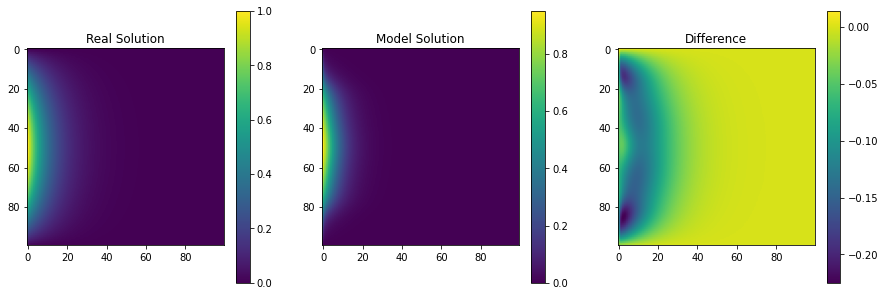

In [14]:
from matplotlib import pyplot as plt
resolution = grid_points_resolution
with torch.no_grad():
    real_solution_plot = equation.real_solution(base_grid_points).cpu().numpy().reshape(resolution,resolution)
    model_solution_plot = model(grid_points).cpu().numpy().reshape(resolution,resolution)
    diff_solution_plot = (model_solution_plot - real_solution_plot)

    fig,ax = plt.subplots(1,3,figsize = (15,5))
    im = ax[0].imshow(real_solution_plot)
    ax[0].set_title("Real Solution")
    fig.colorbar(im, ax=ax[0])
    im = ax[1].imshow(model_solution_plot)
    ax[1].set_title("Model Solution")
    fig.colorbar(im, ax=ax[1])
    im = ax[2].imshow(diff_solution_plot)
    ax[2].set_title("Difference")
    fig.colorbar(im, ax=ax[2])
    plt.show()